In [1]:
# oct 2025
# Dean Winters

import numpy as np
import matplotlib.pyplot as plt

# Will use skimage to read image input; and perform image rotations & resizes
from skimage import io, transform

In [2]:
def hela_pipeline(raw_image, theta):
  # Begins with preprocessing, processing, and analysis

  # ARG:

  # raw_image - input image ndarray. HeLa image in this context
  # theta - takes note of the angle of rotation. Will be important for plotting different environments

  # RETURN:

  # blur_hela - the preprocessed image ndarray
  # fill_mask - the processed image ndarray of each cell masked out
  # largest_cell_area - from analysis, the largest cell area. int
  # largest_cell_centroid_x, largest_cell_centroid_y -from analysis, the location of the centre of the largest area. int,int
  # largest_obj - rectangle frame in the domain of the largest object

  # IMAGE PREPROCESSING :
  # Pipeline:
  # Resize, greyscale, normalise, rolling filter, median filter, gaussian filter

  from skimage import restoration, color, filters
  from scipy.ndimage import median_filter



  # Read, resize and grey the image
  #hela = io.imread("HeLa_cells.jpg")
  #hela = transform.resize(raw_image, (512,512))

  hela = raw_image #fixed
  grey_hela = color.rgb2gray(hela)
  grey_hela = grey_hela / np.max(grey_hela)
  # Apply a rolling filter to help remove some of the residual pixel noise which I assume is due to cell movement
  background_filter = restoration.rolling_ball(grey_hela)
  rolling_ball_hela = grey_hela - background_filter

  # Sharpen with median filter to remove any further noise like salt and pepper noise
  # A larger kernel size is preferable due to the high fluorescence of the HeLa nucleus. One drawback is that this may not remove
  # residual noise (I assume is due to cell movement) as effectively
  mf_hela = median_filter(rolling_ball_hela, size=9)

  # Blur with a Gaussian filter to reduce noise and allow for better resolution/distinction between features with less error
  blur_hela = filters.gaussian(mf_hela)



  # IMAGE PROCESSING :
  # Pipeline:
  # Otsu method -> morphological opening/closing -> fill masking

  from skimage.filters import threshold_otsu
  from skimage import measure, morphology



  # Otsu thresholding - isolate shape from unnecessary background
  threshold_hela = threshold_otsu(blur_hela)
  binary_hela = blur_hela > threshold_hela

  # Morphological operation - apply opening and closing operators to remove small objects in the background and holes in the foreground respectively
  open_binary_hela = morphology.remove_small_objects(binary_hela) #opening
  openclose_binary_hela = morphology.remove_small_holes(open_binary_hela) #closing

  # Masking - even with open and close, the large empty space inside the cell contours means additional work required.
  # Since to this point the image preprocessing and processing has resolved intact and fully enclosed cell contours, apply a "fill" mask
  fill_mask = np.zeros_like(openclose_binary_hela) #template to enter mask
  boundary = fill_mask.shape[0] #image boundary (want to exclude objects which touch the border)

  label = measure.label(openclose_binary_hela) #isolate the cell contours
  objects = measure.regionprops(label) #define and label the cells by their geometry

  # Fill masking technique, and exclude border-touching cells
  for obj in objects:
    contour = obj.convex_image #take the contour
    min_y, min_x, max_y, max_x = obj.bbox #assign the binding coordinates of the shape (min~top left, to max~bottom right)
    check = (min_y == 0 or min_x == 0 or max_y == boundary or max_x == boundary) #check if any coordinates coincide with the image boundary
    if not check:
      fill_mask[min_y:max_y, min_x:max_x][contour] = True #fill in empty frame image and filter boundary cells



  # ANALYSIS :
  # Will isolate the largest cell (largest filled-in mask area)
  # Extract and read out imaged characteristics
  # Display these results



  # For the filled masks, isolate each object and geometric labels as before
  filled_labels = measure.label(fill_mask)
  filled_objs = measure.regionprops(filled_labels)

  # Preprocessing to Processed Visulation:
  plt.imshow(blur_hela)
  plt.title(f"Final Preprocessed Image. rot = {theta} deg.")
  plt.show()
  plt.imshow(fill_mask)
  plt.title(f"Filled Mask Image. rot = {theta} deg.")
  plt.show()


  # PHYSICAL VALUES PRINTOUTS:


  # Find the total number of HeLa cells in the image:

  number_of_HeLa_cells_detected = len(filled_objs)
  print(f"FOR A ROTATION {theta} DEGREES:")
  print(f"There are *{number_of_HeLa_cells_detected}* HeLa cells in HeLa_cell.jpg")

  # Locate, display, highlight the largest cell
  # Display the area and centroid of this cell

  # Area & Centroid
  areas = [int(obj.area) for obj in filled_objs] #deduced areas from fill masking
  largest_cell_area = np.max(areas)
  largest_cell_index = np.argmax(areas)
  largest_cell_centroid_y, largest_cell_centroid_x = filled_objs[largest_cell_index].centroid

  print(f"The area of the largest cell is {largest_cell_area} sq.px")
  print(f"The centroid of the largest cell is located at X: {round(largest_cell_centroid_x)}, Y: {round(largest_cell_centroid_y)} [px,px]")

  # Highlight the cell
  min_y, min_x, max_y, max_x = filled_objs[largest_cell_index].bbox #corners - will plot rectangular outline

  #plt.figure(figsize=(16,6))
  plt.imshow(hela, label=f"No. of cells = {number_of_HeLa_cells_detected}")
  plt.scatter(largest_cell_centroid_x, largest_cell_centroid_y, color="red", label=f"Centroid of largest cell. px - X: {round(largest_cell_centroid_x)}, Y: {round(largest_cell_centroid_y)}") #dot the centroid
  plt.title(f"Largest Cell. rot = {theta} deg. #cells = {number_of_HeLa_cells_detected}")
  # Create rectangle using the four coordinates
  largest_obj = plt.Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, facecolor="none", edgecolor="red", label=f"Region of largest cell. Area = {largest_cell_area} sq.px")
  plt.gca().add_patch(largest_obj)
  plt.legend(loc="lower right")
  plt.show()

  return blur_hela, fill_mask, largest_cell_area, largest_cell_centroid_x, largest_cell_centroid_y, largest_obj




In [3]:
# TEST THE ALGORITHM'S ROBUSTNESS UNDER ROTATION

def algorithm_experiment(input_image, angles):
  # Sets up the robustness under rotation experiment. Take the input image and rotate by angle

  # ARG:
  # angles - the angles of rotation to perform the robustness experiment on. list
  # input_image - raw image ndarray. To undergo each iteration of the hela_pipeline()

  # RETURN:
  # not necessary at the moment as hela_pipeline() was designed to be self-contained and display the pertinent results ...
  # results - storage of results of blur_hela, fill_mask, largest_cell_area, largest_cell_centroid_x, largest_cell_centroid_y, largest_obj


  results = []
  for angle in angles:
    print(f"{angle}-rotated:")

    rotated_image = transform.rotate(input_image, angle, preserve_range=True, resize=False)

    run_experiment = hela_pipeline(rotated_image, angle)
    results.append(run_experiment)

  return results



0-rotated:


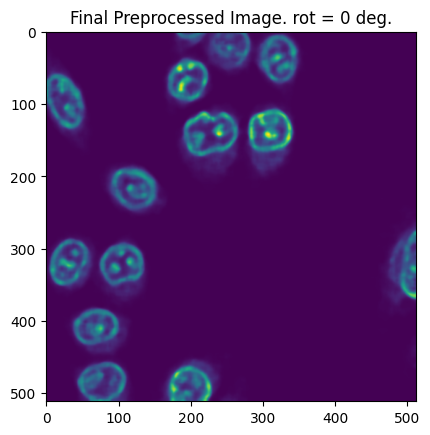

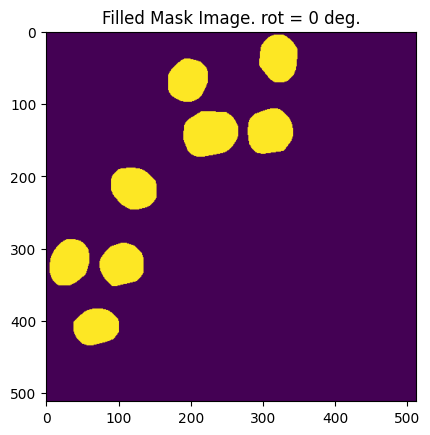

FOR A ROTATION 0 DEGREES:
There are *8* HeLa cells in HeLa_cell.jpg
The area of the largest cell is 3913 sq.px
The centroid of the largest cell is located at X: 227, Y: 141 [px,px]


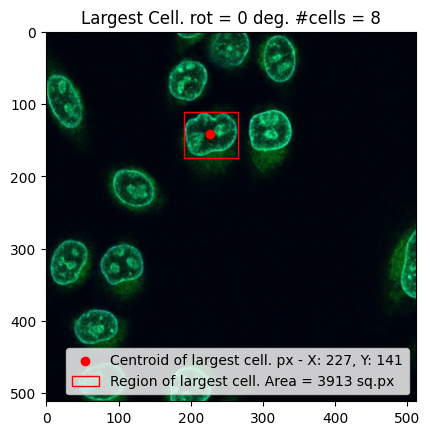

90-rotated:


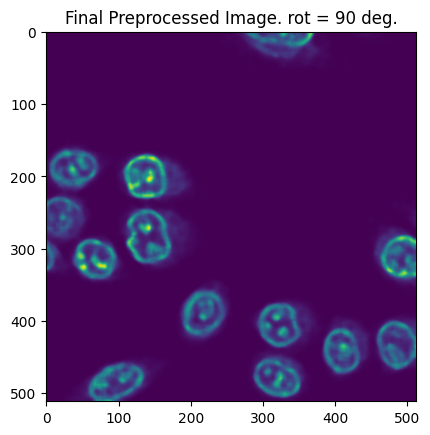

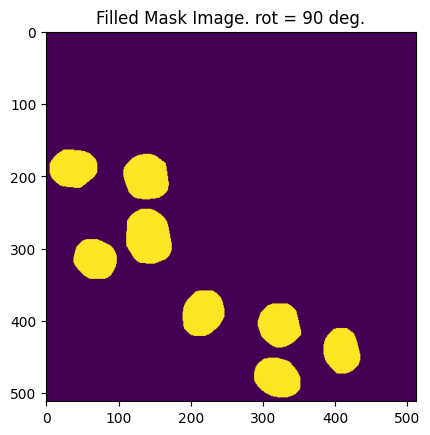

FOR A ROTATION 90 DEGREES:
There are *8* HeLa cells in HeLa_cell.jpg
The area of the largest cell is 3913 sq.px
The centroid of the largest cell is located at X: 141, Y: 284 [px,px]


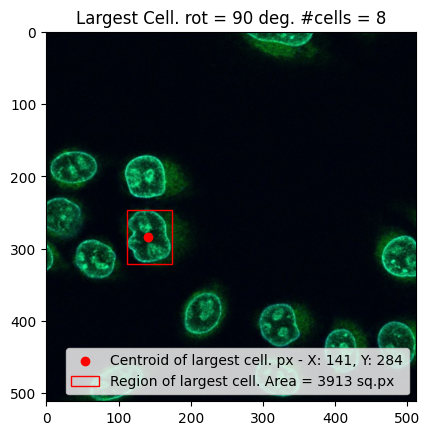

180-rotated:


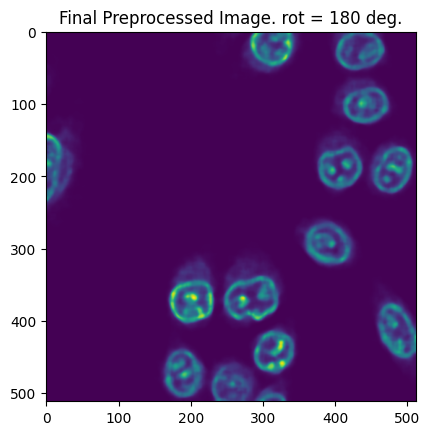

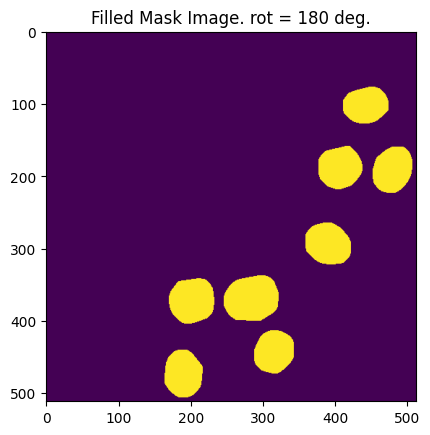

FOR A ROTATION 180 DEGREES:
There are *8* HeLa cells in HeLa_cell.jpg
The area of the largest cell is 3913 sq.px
The centroid of the largest cell is located at X: 284, Y: 370 [px,px]


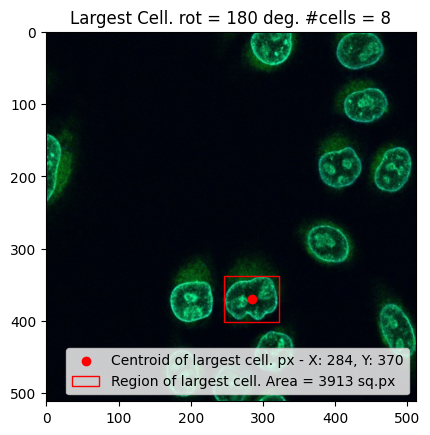

270-rotated:


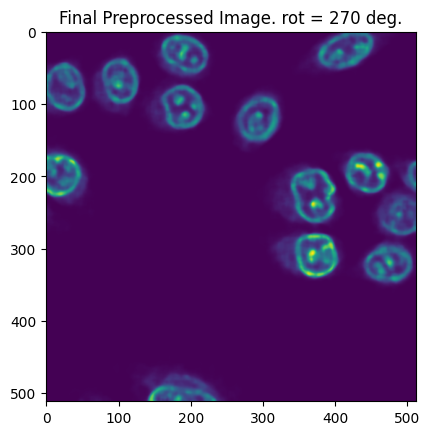

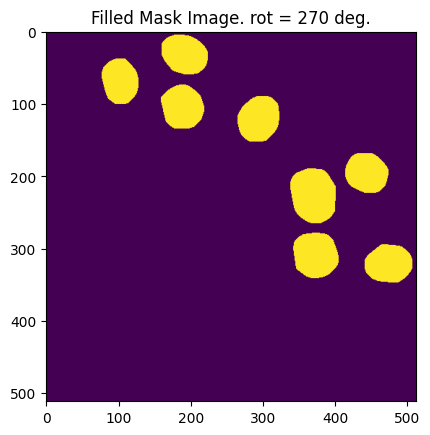

FOR A ROTATION 270 DEGREES:
There are *8* HeLa cells in HeLa_cell.jpg
The area of the largest cell is 3913 sq.px
The centroid of the largest cell is located at X: 370, Y: 227 [px,px]


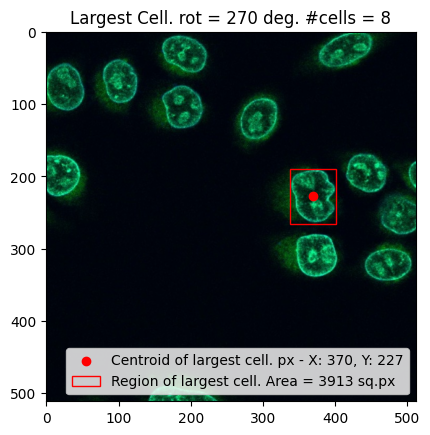

360-rotated:


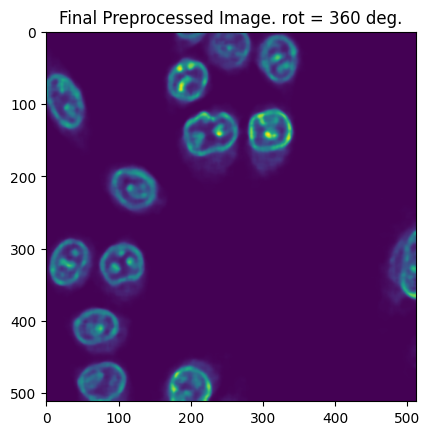

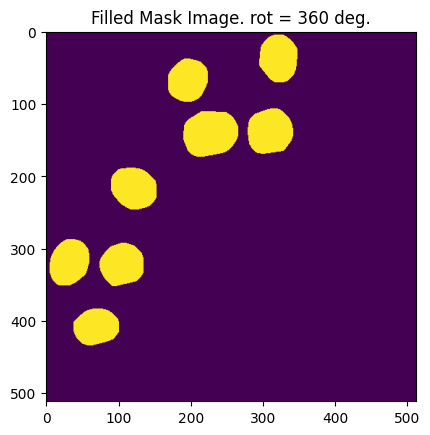

FOR A ROTATION 360 DEGREES:
There are *8* HeLa cells in HeLa_cell.jpg
The area of the largest cell is 3913 sq.px
The centroid of the largest cell is located at X: 227, Y: 141 [px,px]


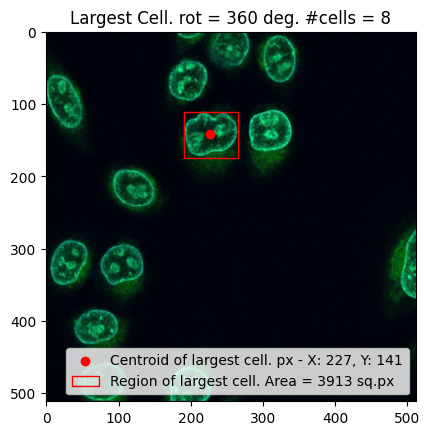

In [4]:
# FULL EXPERIMENT EXECUTION
# runtime approx 2.5mins on home machine
# (~30s per rotation, 360deg rotation included for completeness)

# Read raw image:
raw_hela = io.imread("HeLa_cells.jpg")

# Resize to 512x512 px:
resized_hela = transform.resize(raw_hela, (512,512))

# Run on each right-hand turn of the image. Working with dTheta < 90deg would break the pipeline.
# It is only capable on square-framed images.
test_angles = [0,90,180,270,360]

# Store experimental data - not necessary to call on currently.
data = algorithm_experiment(resized_hela, test_angles)